In [43]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal
import pandas as pd
import plotly.graph_objects as go
from numba import jit
from matplotlib import cm

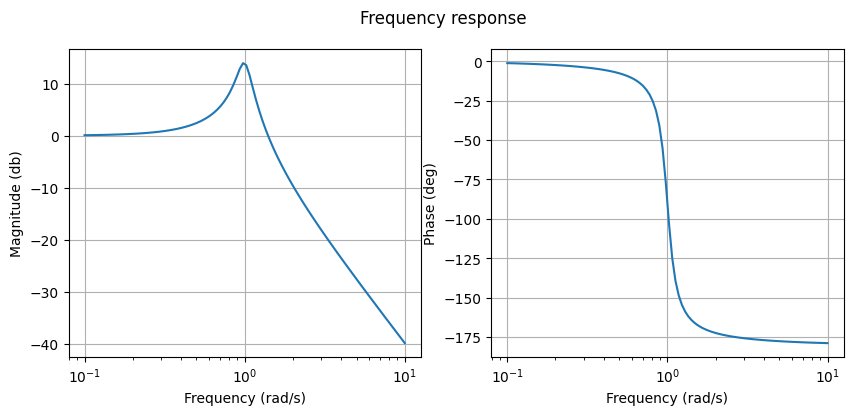

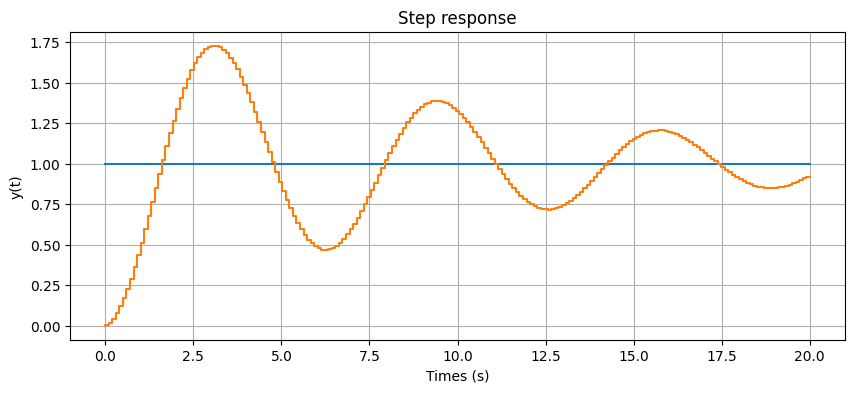

In [44]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lti.html
#G(s) = 1/(s^2 + 0.2s + 1)

system = num, den = [1],[1, .2, 1]

g1=signal.lti([1],[1, .2, 1]) 
g2=signal.lti([3],[1, 2, 1])

# Discretization time step
dt = 0.1 #s

# Simulation time
T = 20 #s

# Samples
samples = int(T/dt)

#gd = signal.cont2discrete(system,dt=dt,method='zoh')

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lti.bode.html#scipy.signal.lti.bode
w, mag, phase = g1.bode()

fig, axes = plt.subplots(1,2,figsize=(10,4))

axes[0].semilogx(w, mag)    # Bode magnitude plot
axes[1].semilogx(w, phase)  # Bode phase plot
for ax in axes:
    ax.grid()
    ax.set_xlabel("Frequency (rad/s)")
axes[0].set_ylabel("Magnitude (db)");
axes[1].set_ylabel("Phase (deg)");

fig.suptitle("Frequency response")

fig, ax = plt.subplots(figsize=(10,4))


t = np.linspace(0, T, samples)
x = np.ones(samples)
t,y,_ = signal.lsim(g1,x,t)
ax.step(t,x)
ax.step(t,y)

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("y(t)")
ax.set_title("Step response");

In [45]:
# load both PRBS signals from file 
data=np.genfromtxt('idinp.csv',dtype=float,delimiter=',',skip_header=1)

In [46]:
t1=np.linspace(0,79.9,800)   # first time interval, for g1
t2=np.linspace(80,119.9,400) # second time interval, for g2
t=np.concatenate((t1,t2))

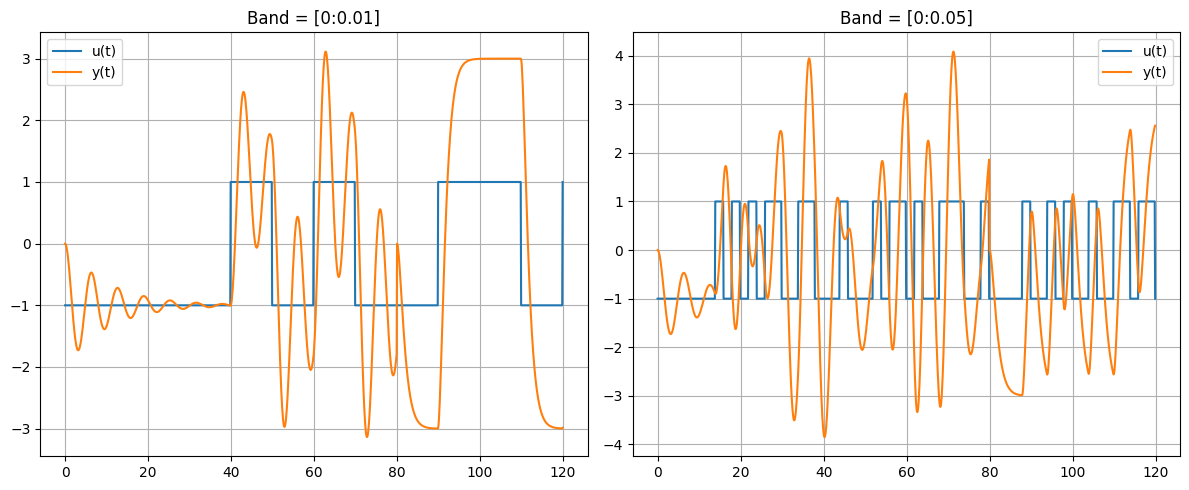

In [47]:
bands = [.01,.05]
us = []
ys = []

for i,band in enumerate(bands):
    u= data[:,i]
    u1=u[0:800]     
    u2=u[800:1200]  
    to1,y1,x1=signal.lsim(g1,u1,t1)
    to2,y2,x2=signal.lsim(g2,u2,t2,X0=x1[-1])

    u=np.concatenate((u1,u2))
    y_ref=np.concatenate((y1,y2))

    us.append(u)
    ys.append(y_ref)


fig,axes = plt.subplots(1,2,figsize=(12,5),dpi=100)

for i,ax in enumerate(axes):
    ax.plot(t,us[i],label="u(t)")
    ax.plot(t,ys[i],label="y(t)")
    ax.set_title(f"Band = [0:{bands[i]}]")
    ax.grid()
    ax.legend()

fig.tight_layout()

In [48]:
@jit(nopython=True)
def adaline(u,y,delays,mu,adapt=True,wt=None):                          # receives (u) or ,(u,w) - produces ys

    # Initialize weights
    if adapt:
        # adapt weights w
        w = np.zeros(delays,dtype=float)
    else:
        # receive and mantain w - simulate only
        w = wt

     # Register time evolution of the weights
    wt= np.zeros((len(u),delays),dtype=float) 

    # Network output for each input in p
    ys= np.zeros(len(u), dtype=float)
    
    # Register time evolution of the error
    et= np.zeros(len(u), dtype=float)
    err=0

    # Fill in "acausal" zeros , for t<0
    ud=np.zeros(delays,dtype=float)     
    #ue=np.insert(ud,delays,u)       #(1204,)
    ue = np.concatenate((ud,u))
    for i in range(len(u)):                             # Iterate over the inputs
        for j in range(delays): ys[i]+=ue[i-j]*w[j]     # Compute w*x as the inputs slide through the weights
        for j in range(delays): 
            et[i]=y[i]-ys[i]                            # Store the computed error
            if adapt:
                w[j]+=mu*et[i]*ue[i-j]               # Widrow-Hoff delta rule
                wt[i,j] = w[j]                       # Store w history
        aux = (y[i]-ys[i])**2
        err+= aux
        

    mse=err/len(u)
    
    return ys, et, mse, wt

In [49]:
min_val, max_val, samples = 1e-5,.5,1000
list_delays = np.arange(4,20+1,1,dtype=np.int32)  # order of the FIR
mus = np.linspace(min_val, max_val, samples)        # learning rate
aux = 2,list_delays.shape[0], mus.shape[0]
mseas = np.zeros(aux,dtype=np.float64)
msefs = np.zeros(aux,dtype=np.float64)
mseds = np.zeros(aux,dtype=np.float64)
cont = 0
for i in range(list_delays.shape[0]):
    delays = list_delays[i]
    for j in range(mus.shape[0]):
        mu = mus[j]
        for b,band in enumerate(bands):
            cont+=1
            ya, e, a, wt = adaline(us[b],ys[b],delays,mu)

            mseas[b,i,j] = msea

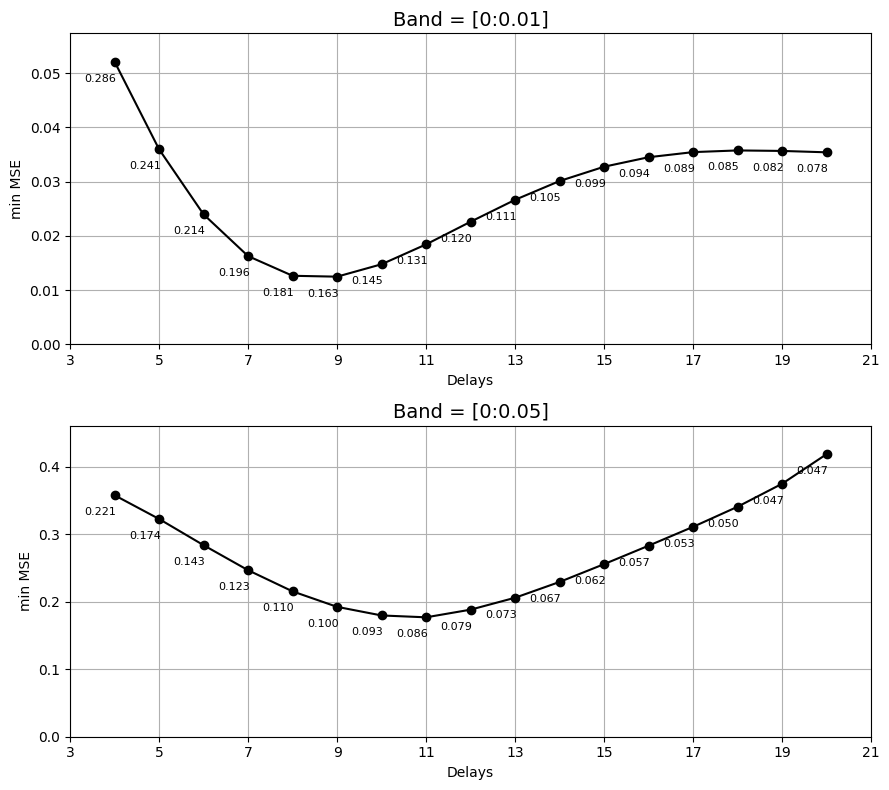

In [54]:
fig, axes = plt.subplots(2,1,figsize=(9,8))
z_mins = []
x_mins = []
for b,ax in enumerate(axes):
    x,y,z = mus, list_delays,  mseas[b,:,:].copy()
    z_min = np.nanmin(z,axis=1)
    df = pd.DataFrame(z.T)
    x_min_idx = df.idxmin(axis=0).to_numpy()
    x_min = x[x_min_idx]


    z_mins.append(z_min)
    x_mins.append(x_min)
    #ax.set_xlim(3,21)
    ax.set_ylim(0.0,z_min.max()*1.1)
    ax.plot(y,z_min,"-ok")
    ax.set_xlabel("Delays")
    ax.set_ylabel("min MSE")
    ax.set_title("")
    ax.set_xticks(ticks=range(3,22,2), minor=False)
    ax.grid()
    ax.set_title(f"Band = [0:{bands[b]}]",fontsize=14)

    for i in range(len(y)):
        ax.annotate(f"{x_min[i]:.3f}", (y[i], z_min[i]), xytext=(-30, -20), textcoords="offset pixels",fontsize=8)

fig.tight_layout()




In [55]:
for b, band in enumerate(bands):

    z = mseas[b,:,:].copy()

    th =  1.01*z_mins[b].max()
    z[z>th] = th
    fig = go.Figure(data=[go.Surface(z=z,y=y,x=x)])
    fig.update_layout(autosize=False,
                    title="de",
                    margin=dict(l=0, r=0, b=0, t=0)
                    )

    fig.update_layout(scene = dict(
                        xaxis_title='Learning Rate',
                        yaxis_title='Delays',
                        zaxis_title='MSE'),
                        width=800, height=800,
                        )

    fig.show()

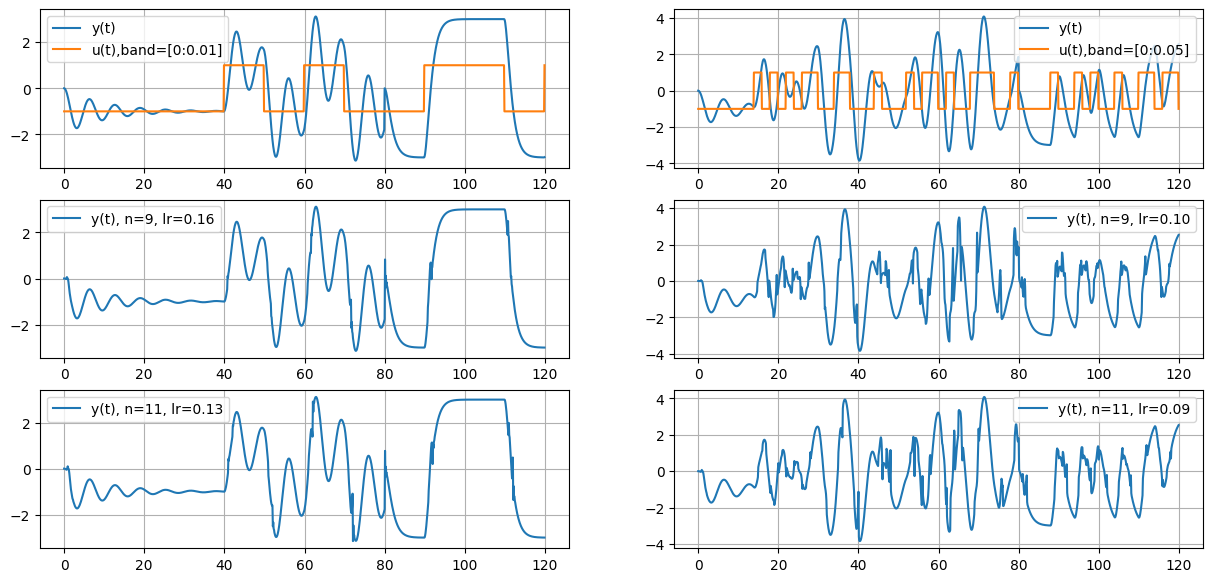

In [57]:
selected_delays= [5,7]
fig, axes = plt.subplots(len(selected_delays)+1,2,figsize=(15,7))

for b, band in enumerate(bands):
    axes[0,b].plot(t,ys[b],label="y(t)")
    axes[0,b].plot(t,us[b],label=f"u(t),band=[0:{band}]")
    axes[0,b].grid()
    axes[0,b].legend()

for i,idx_delays in enumerate(selected_delays):
    for b, band in enumerate(bands):
        ax = axes[i+1,b]
        delays = list_delays[idx_delays]
        mu= x_mins[b][idx_delays]
        ya, e, msea, wt = adaline(us[b],ys[b],delays,mu)
        ax.plot(t, ya,label=f"y(t), n={delays}, lr={mu:.2f}")
        ax.grid()
        ax.legend()


In [84]:
mseds = np.zeros((2,list_delays.shape[0]))
for i,delays in enumerate(list_delays):
    for b, band in enumerate(bands):

        # NEWLIND - Design a ADALINE using all samples at once: the pseudoinverse
        U=np.zeros((len(u)+delays,delays))
        for j in range(delays):         # build U with copies of shifted u
            U[j:len(u)+j,j]=u

        Y=np.zeros((len(u)+delays))
        Y[0:len(y)]=y

        #wd = inv(U'U)*U'*y
        wd = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(U),U)),np.transpose(U)),Y)


        # NEWLIND Fixed weights wd - Designed
        yd, e, msed, wr = adaline(us[b],ys[b],delays,mu,False,wd)
        mseds[b,i] = msed


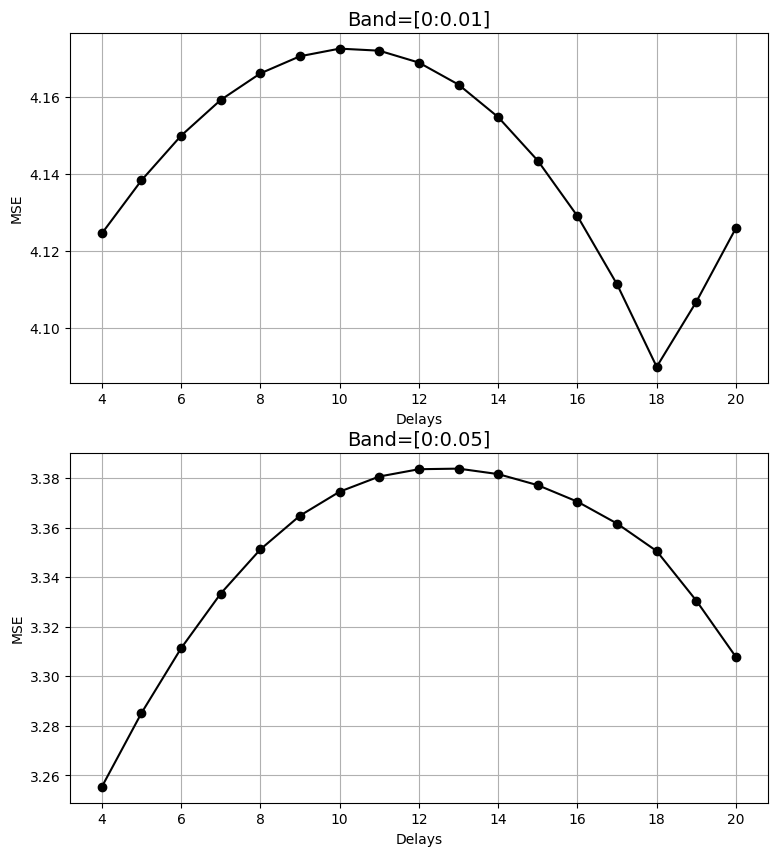

In [115]:
fig, axes = plt.subplots(2,1,figsize=(9,10),dpi=100)
for i, ax in enumerate(axes):
    ax.plot(list_delays,mseds[i],"-ok")
    ax.grid()
    ax.set_xlabel("Delays")
    ax.set_ylabel("MSE")
    ax.set_title(f"Band=[0:{bands[i]}]",fontsize=14)

4
18


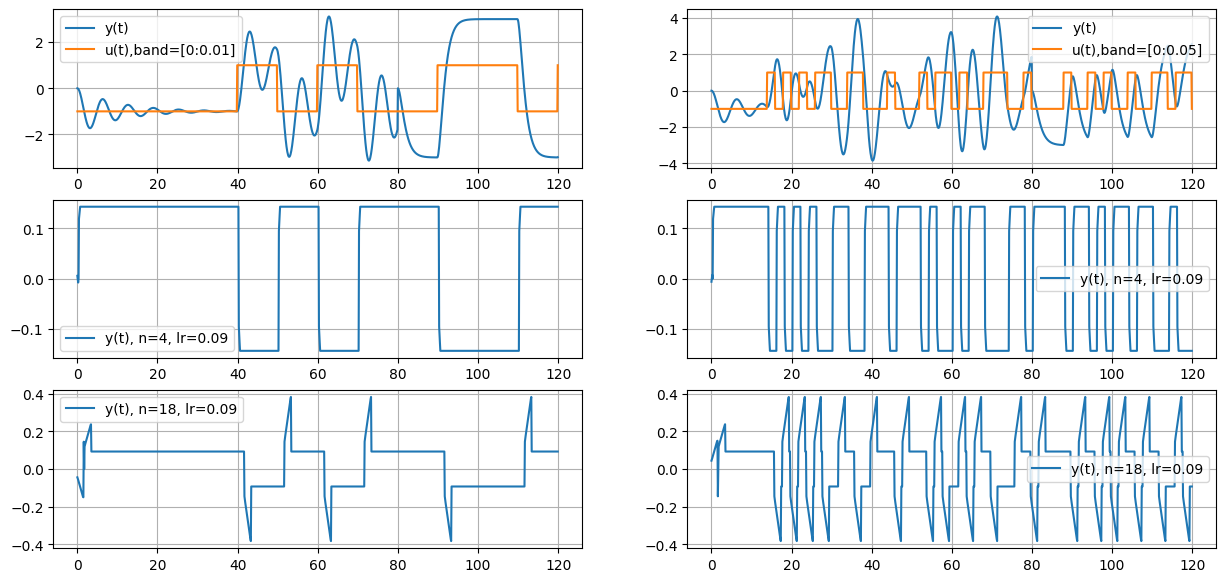

In [120]:
selected_delays= [0,14]

fig, axes = plt.subplots(len(selected_delays)+1,2,figsize=(15,7))

for b, band in enumerate(bands):
    axes[0,b].plot(t,ys[b],label="y(t)")
    axes[0,b].plot(t,us[b],label=f"u(t),band=[0:{band}]")
    axes[0,b].grid()
    axes[0,b].legend()

for i,idx_delays in enumerate(selected_delays):
    delays = list_delays[idx_delays]
    print(delays)
    for b, band in enumerate(bands):
        yd, e, msed, wr = adaline(us[b],ys[b],delays,mu,False,wd)
        axes[i+1,b].plot(t,yd,label=f"y(t), n={delays}, lr={mu:.2f}")
        axes[i+1,b].grid()
        axes[i+1,b].legend()